In [1]:
from datasets import load_dataset
data = load_dataset("../data/20230419_224x224/20230419_224x224.py", cache_dir="/pscratch/sd/s/shubh/")

Found cached dataset 20230419_224x224 (/pscratch/sd/s/shubh/20230419_224x224/first_domain/1.1.0/09ca5b8cc58d1d3ba6ea901ee6712e987b511b5da6e12fc36863d53a37c994e7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
data

DatasetDict({
    train: Dataset({
        features: ['As', 'bary_Mc', 'bary_nu', 'H0', 'O_cdm', 'O_nu', 'Ob', 'Om', 'ns', 's8', 'w0', 'sim_type', 'sim_name', 'map'],
        num_rows: 135730
    })
    validation: Dataset({
        features: ['As', 'bary_Mc', 'bary_nu', 'H0', 'O_cdm', 'O_nu', 'Ob', 'Om', 'ns', 's8', 'w0', 'sim_type', 'sim_name', 'map'],
        num_rows: 16940
    })
    test: Dataset({
        features: ['As', 'bary_Mc', 'bary_nu', 'H0', 'O_cdm', 'O_nu', 'Ob', 'Om', 'ns', 's8', 'w0', 'sim_type', 'sim_name', 'map'],
        num_rows: 16940
    })
})

In [3]:
# id2label = {id:label for id, label in enumerate(data["train"].features) if label != "map"}
id2label = {id:label for id, label in enumerate(["Om", "s8"])}
label2id = {label:id for id,label in id2label.items()}
id2label, label2id

({0: 'Om', 1: 's8'}, {'Om': 0, 's8': 1})

In [4]:
import numpy as np 
from matplotlib import pyplot as plt
from PIL import Image
import torch

size = (224, 224)

print(size)

from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomVerticalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

normalize = Normalize(mean=0, std=1)

train_data_augmentation = Compose(
        [
            RandomHorizontalFlip(),
            RandomVerticalFlip(),
            normalize,
        ]
    )

val_data_augmentation = Compose(
        [
            normalize,
        ]
    )

def preprocess_train(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Om", "s8"]]).astype(np.float32)
    examples['pixel_values'] = [train_data_augmentation(torch.swapaxes(torch.Tensor(np.array(image)), 0, 2)) for image in examples['map']]
    return examples

def preprocess_val(examples):
    # examples["labels"] = np.transpose([examples[x] for x in examples.keys() if x != "map"]).astype(np.float32)
    examples["labels"] = np.transpose([examples[x] for x in ["Om", "s8"]]).astype(np.float32)
    examples['pixel_values'] = [val_data_augmentation(torch.swapaxes(torch.Tensor(np.array(image)), 0, 2)) for image in examples['map']]
    return examples

data["train"].set_transform(preprocess_train)
data["validation"].set_transform(preprocess_val)
data["test"].set_transform(preprocess_val)

(224, 224)


In [5]:
(data["train"][0]["labels"])

array([0.32286683, 0.7927383 ], dtype=float32)

In [6]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(data["train"], collate_fn=collate_fn, batch_size=32)
val_dataloader = DataLoader(data["validation"], collate_fn=collate_fn, batch_size=32)

# batch = next(iter(train_dataloader))
# for k,v in batch.items():
#     if isinstance(v, torch.Tensor):
#         print(k, v.shape)

In [7]:
import torch
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
print(torch.cuda.get_device_name(0))

Using cache found in /global/homes/s/shubh/.cache/torch/hub/pytorch_vision_v0.10.0
/global/cfs/cdirs/des/shubh/.conda/envs/vit/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/global/cfs/cdirs/des/shubh/.conda/envs/vit/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


NVIDIA A100-PCIE-40GB


In [8]:
from torch import nn
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=len(id2label), bias=True)
def dropout(model, rate):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            dropout(module, rate)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate))
            setattr(model, name, new)

dropout(model, 0.1)

In [9]:
num_channels = 4
model.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)

In [10]:
model

ResNet(
  (conv1): Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): Sequential(
    (0): ReLU(inplace=True)
    (1): Dropout2d(p=0.1, inplace=False)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): Sequential(
        (0): ReLU(inplace=True)
 

In [10]:
import tqdm

device = torch.device("cuda:0")

def train_model(model, 
                data_loader, 
                val_data_loader,
                dataset_size, 
                val_size, 
                optimizer, 
                num_epochs):
    model.to(device)
    criterion = nn.MSELoss()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        model.train()

        running_loss = 0.0
        # Iterate over data.
        for bi, d in enumerate(tqdm.tqdm(data_loader)):
            inputs = d["pixel_values"]
            labels = d["labels"]
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / dataset_size
        print('Loss: {:.4f}'.format(epoch_loss))
        
        model.eval()
        running_loss = 0.0
        # Iterate over data.
        for bi, d in enumerate(tqdm.tqdm(val_data_loader)):
            inputs = d["pixel_values"]
            labels = d["labels"]
            inputs = inputs.to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.float)

            with torch.no_grad():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_loss / val_size
        print('Val Loss: {:.4f}'.format(epoch_val_loss))
    return model

In [11]:
from transformers import AdamW

learning_rate = 0.001
weight_decay_rate = 0.001

optimizer = AdamW(model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay_rate)

2023-05-26 07:57:59.605925: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-26 07:58:05.534526: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/global/cfs/cdirs/des/shubh/.conda/envs/vit/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [12]:
model = train_model(model, train_dataloader, val_dataloader, len(data["train"]), len(data["validation"]), optimizer, 2)

Epoch 0/1
----------


  0%|          | 0/4242 [00:00<?, ?it/s]/tmp/ipykernel_238003/1119673828.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  labels = torch.tensor([example["labels"] for example in examples])
100%|██████████| 4242/4242 [2:33:06<00:00,  2.17s/it]  


Loss: 0.0326


100%|██████████| 530/530 [20:47<00:00,  2.35s/it]


Val Loss: 0.0212
Epoch 1/1
----------


100%|██████████| 4242/4242 [2:48:59<00:00,  2.39s/it]  


Loss: 0.0093


100%|██████████| 530/530 [19:15<00:00,  2.18s/it]

Val Loss: 0.0128


In [15]:
from pathlib import Path

# out_dir = "../models/20230905_vit/"
out_dir = "../models/20230526_resnet_2_var_dropout/"
Path(out_dir).mkdir(parents=True, exist_ok=True)

torch.save(model, out_dir + 'model.pth')

In [168]:
del inputs

In [169]:
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

6138587136
6138587136


In [ ]:
n_pred = 5

preds = np.empty((n_pred, len(data["validation"]), 2))
label_ids = []

val_dataloader = DataLoader(data["validation"], collate_fn=collate_fn, batch_size=32)

for i in range(n_pred):
    if i % 2 == 0: 
        print(i)
    ps = []
    model.train()
    for bi, d in enumerate(tqdm.tqdm(val_dataloader)):
        inputs = d["pixel_values"]
        inputs = inputs.to(device, dtype=torch.float)
        outputs = model(inputs)
        if i == 0:
            label_ids += d["labels"]
        preds[i, bi*32 : (1+bi)*32] = outputs.detach().cpu().numpy()
        
label_ids = torch.stack(label_ids)
preds, label_ids

0


100%|██████████| 530/530 [18:46<00:00,  2.12s/it]


2


 10%|█         | 55/530 [01:55<17:13,  2.18s/it]

In [ ]:
plot_y = label_ids
predictions_best = np.nanmean(preds, axis=0)
predictions_std = np.nanstd(preds, axis=0)

upp_lims = np.nanmax(plot_y, axis=0)
low_lims = np.nanmin(plot_y, axis=0)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax, low_lim, upp_lim) in enumerate(zip(labels, axs.ravel(), low_lims, upp_lims)):
    p = np.poly1d(np.polyfit(plot_y[:, ind], predictions_best[:, ind], 1))
    ax.errorbar(plot_y[:, ind][::10], predictions_best[:, ind][::10],  predictions_std[:, ind][::10], marker="x", ls='none', alpha=0.4)
    # ax.errorbar(plot_y[:, ind][::10], predictions_best[:, ind][::10],  0, marker="x", ls='none', alpha=0.4)
    ax.set_xlabel("true")
    ax.set_ylabel("prediction")
    ax.plot([low_lim, upp_lim], [low_lim, upp_lim], color="black")
    ax.plot([low_lim, upp_lim], [p(low_lim), p(upp_lim)], color="black", ls=":")
    ax.set_xlim([low_lim, upp_lim])
    ax.set_ylim([low_lim, upp_lim])
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(label)
    ax.grid()
plt.savefig("./temp.pdf")
plt.close()

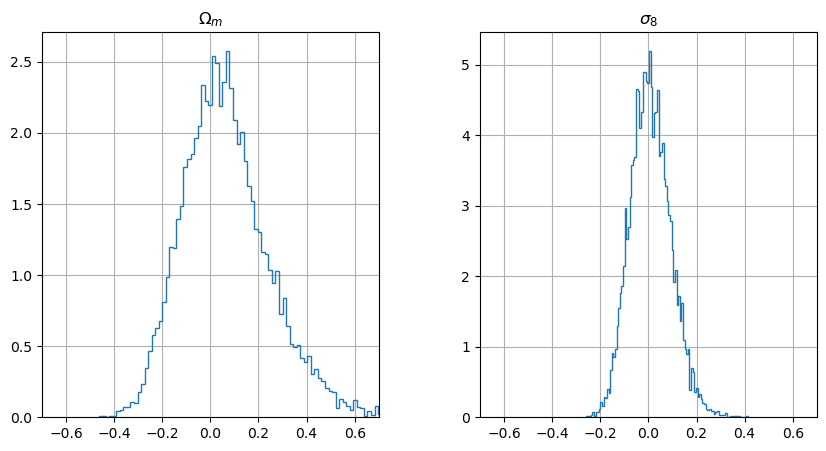

In [177]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.3, hspace=0.2)
labels = [r"$\Omega_m$", r"$\sigma_8$"]
for ind, (label, ax) in enumerate(zip(labels, axs.ravel())):
    ax.hist((plot_y[:, ind] - predictions_best[:, ind]) / predictions_best[:, ind], bins=100, density=True, histtype="step")
    ax.set_title(label)
    ax.set_xlim([-0.7, 0.7])
    ax.grid()
plt.show()
plt.close()

In [178]:
indexes = [5056, 8110, 3840, 1028, 7385]

0


100%|██████████| 32/32 [00:16<00:00,  1.92it/s]


[0.18261719 0.88779294]
[0.44228075 0.23706046] [0.43235153 0.25198117]


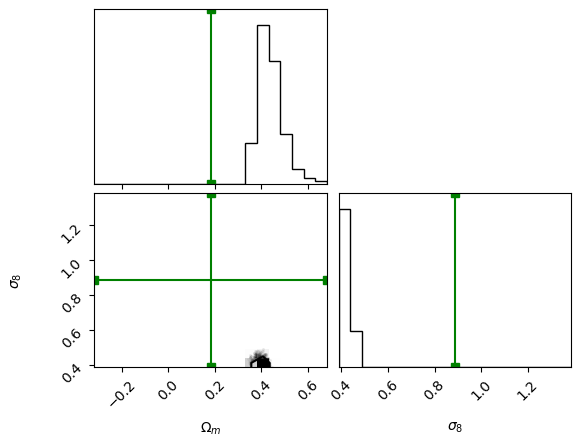

1


100%|██████████| 32/32 [00:17<00:00,  1.86it/s]


[0.4408203 0.5977539]
[0.44228075 0.23706046] [0.43235153 0.25198117]


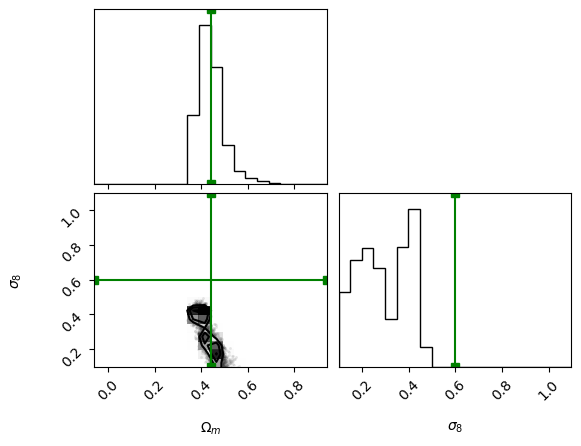

2


100%|██████████| 32/32 [00:15<00:00,  2.00it/s]


[0.3953125 0.8179687]
[0.44228075 0.23706046] [0.43235153 0.25198117]


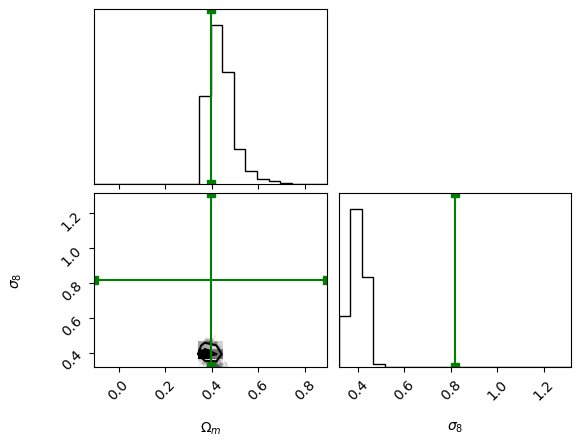

3


100%|██████████| 32/32 [00:15<00:00,  2.05it/s]


[0.37441406 0.46689454]
[0.44228075 0.23706046] [0.43235153 0.25198117]


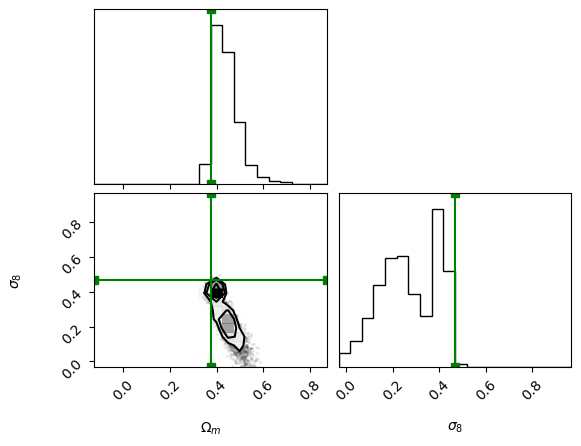

4


100%|██████████| 32/32 [00:16<00:00,  1.99it/s]


[0.17050782 1.1329101 ]
[0.44228075 0.23706046] [0.43235153 0.25198117]


ValueError: It looks like the provided 'range' is not valid or the sample is empty.

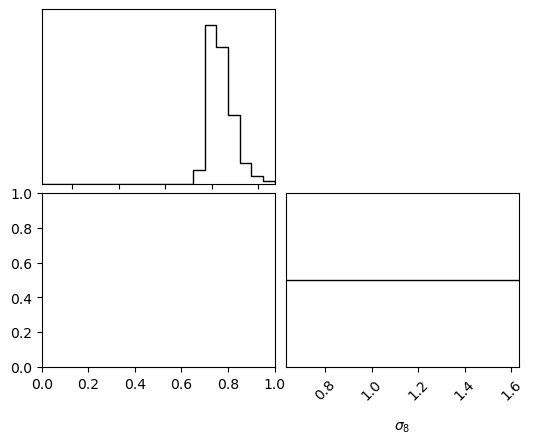

In [179]:
from datasets import Dataset
import corner 

n_pred = 1001

for ind in range(5):
    print(ind)
    preds = np.empty((n_pred, 2))
    index = indexes[ind]
    data_repeat = {}
    for key, val in data["validation"][index:index+1].items():
        if key == "labels":
            data_repeat[key] = np.repeat(val, n_pred, axis=0)
            continue
        data_repeat[key] = val * n_pred    
    datapoint = Dataset.from_dict(data_repeat)
    datapoint.set_transform(preprocess_val)

    val_dataloader = DataLoader(datapoint, collate_fn=collate_fn, batch_size=32)

    model.train()
    for bi, d in enumerate(tqdm.tqdm(val_dataloader)):
        inputs = d["pixel_values"]
        inputs = inputs.to(device, dtype=torch.float)
        outputs = model(inputs)
        preds[bi*32 : (1+bi)*32] = outputs.detach().cpu().numpy()
    
    labels = lab_x, lab_y = data["validation"][index:index+1]["labels"][0]
    margin = 5e-1
    print(labels)
    print(np.nanmean(preds_one, axis=0), np.nanmedian(preds_one, axis=0))
    fig = plt.figure()
    corner.corner(preds_one, fig=fig, labels=[r"$\Omega_m$", r"$\sigma_8$"], \
                  range=[(lab_x-margin, lab_x+margin), (lab_y-margin, lab_y+margin)])
    corner.overplot_lines(fig, labels, marker="s", color="green")
    plt.show()
    plt.close()